In [6]:
# Processor requirements
# The first two cells must be code cells, inpath and outpath define the scan file location and output location
inpath = '/dls/i16/data/2025/mm41580-1/processed/1114510_msmapper.nxs'

In [2]:
outpath = ""

# Plot msmapper HKL cuts

This notebook automatically loads remapped HKL volumes resulting from the MillerSpaceMapper software on I16 and plots cuts along the pricipal axes.

See https://confluence.diamond.ac.uk/display/I16/HKL+Mapping


Running MillSpaceMapper from command line:
```bash
module load msmapper
rs_map -s 0.002 -o /dls/i16/data/2022/mm12345-1/processing/12345_remap.nxs /dls/i16/data/2022/mm12345-1/12345.nxs
```

Running this notebook from command line:
```bash
module load python/3
python /dls_sw/i16/software/python/jupyter_processor/jproc.py mapper /dls/i16/data/2022/mm12345-1/12345.nxs
```

Using the autoprocessing in GDA on I16:
```python
from gda.device.scannable import ProcessingScannable
remapHKLcuts = ProcessingScannable('remapHKLcuts')
remapHKLcuts['msmapper'] = "{'notebook': '/dls_sw/i16/software/python/userscripts/i16user/jupyter_processors/msmapper_processor.ipynb'}"
scancn eta 0.001 101 remapHKLcuts pil 1  # results will appear in ispyb
```

In [3]:
import sys, os
import glob, time
import numpy as np
import matplotlib.pyplot as plt

# Import BabelScan
sys.path.append('/dls_sw/i16/software/python/babelscan')
from babelscan import file_loader

In [4]:
sys.path.append("/dls_sw/i16/software/daqmessenger")
daq = None
try:
    from daqmessenger import DaqMessenger
    daq = DaqMessenger("i16-control")
    daq.connect()
    daq.send_file(inpath)
    daq.disconnect()
except:
    print("no messenger")




no messenger


In [7]:
# Get remapped file
print(inpath)
print(outpath)
scan = file_loader(inpath)
print(scan)

/dls/i16/data/2025/mm41580-1/processed/1114510_msmapper.nxs

HdfScan(filename: /dls/i16/data/2025/mm41580-1/processed/1114510_msmapper.nxs, namespace: 3, associations: 8)
        scan_command = scan eta_fly_fly (33.767,33.773,33.779,33.785,33.791,33.797,33.803,33.809,33.815,33.821,33.827,33.83 ...
              h-axis = (140,) max: 2.448, min: 2.17, mean: 2.309
              volume = (140, 49, 206) max: 3.4428e+11, min:    0, mean: 3.6759e+09


In [8]:
# If scan is a standard nexus file, not a remapped file, look for the remapped file in the processing folder

try:
    vol = scan['volume']
    remap = scan
    print('File contains remapped data')
except Exception:
    # Find remapped files
    expdir = os.path.dirname(scan.filename) 
    for ntries in range(10):
        # remapping may take some time, so keep checking until finished
        remap_files = glob.glob(expdir + '/processed/*.nxs') 
        rmf = [file for file in remap_files if str(scan.scan_number) in file]
        if len(rmf) > 0:
            remap = file_loader(rmf[0])
            try:
                vol = remap['volume']
            except Exception:
                time.sleep(60) # wait for file to finish writing
                remap = file_loader(rmf[0])
            break
        else:
            print('Remapped file does not exist yet, try again in 1 min')
            time.sleep(60)

    print('Remapped file loaded: %s' % remap.filename)

File contains remapped data


In [9]:
# Get reciprocal space data from file
h = remap['h-axis']
k = remap['k-axis']
l = remap['l-axis']
vol = remap['volume']

print('\n'.join(remap.string(['h-axis', 'k-axis', 'l-axis', 'volume'])))

              h-axis = (140,) max: 2.448, min: 2.17, mean: 2.309
              k-axis = (49,) max: 0.746, min: 0.65, mean: 0.698
              l-axis = (206,) max: 0.102, min: -0.308, mean: -0.103
              volume = (140, 49, 206) max: 3.4428e+11, min:    0, mean: 3.6759e+09


Text(0, 0.5, 'sum axes [0,1]')

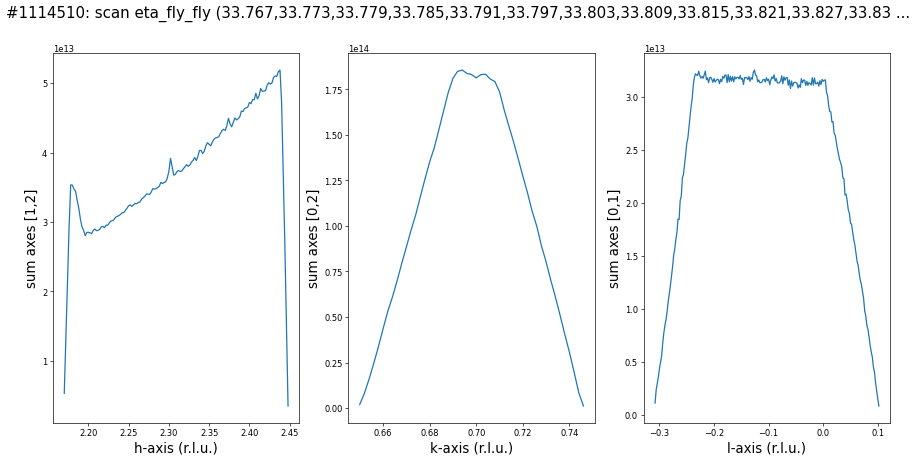

In [10]:
# Plot summed cuts
plt.figure(figsize=[18, 8], dpi=60)
title = scan.string_format('#{scan_number:.0f}: {scan_command}') 
plt.suptitle(title, fontsize=18)

plt.subplot(131)
plt.plot(h, vol.sum(axis=1).sum(axis=1))
plt.xlabel('h-axis (r.l.u.)', fontsize=16)
plt.ylabel('sum axes [1,2]', fontsize=16)

plt.subplot(132)
plt.plot(k, vol.sum(axis=0).sum(axis=1))
plt.xlabel('k-axis (r.l.u.)', fontsize=16)
plt.ylabel('sum axes [0,2]', fontsize=16)

plt.subplot(133)
plt.plot(l, vol.sum(axis=0).sum(axis=0))
plt.xlabel('l-axis (r.l.u.)', fontsize=16)
plt.ylabel('sum axes [0,1]', fontsize=16)

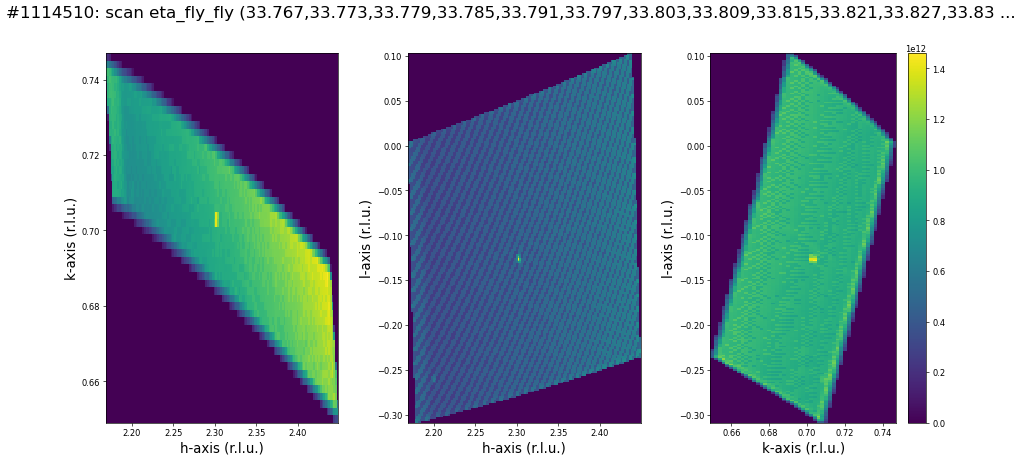

In [11]:
# Plot summed images
plt.figure(figsize=[18, 8], dpi=60)
title = scan.string_format('#{scan_number:.0f}: {scan_command}') 
plt.suptitle(title, fontsize=20)
plt.subplots_adjust(wspace=0.3)

plt.subplot(131)
K, H = np.meshgrid(k, h)
plt.pcolormesh(H, K, vol.sum(axis=2))
plt.xlabel('h-axis (r.l.u.)', fontsize=16)
plt.ylabel('k-axis (r.l.u.)', fontsize=16)
#plt.axis('image')
#plt.colorbar()

plt.subplot(132)
L, H = np.meshgrid(l, h)
plt.pcolormesh(H, L, vol.sum(axis=1))
plt.xlabel('h-axis (r.l.u.)', fontsize=16)
plt.ylabel('l-axis (r.l.u.)', fontsize=16)
#plt.axis('image')
#plt.colorbar()

plt.subplot(133)
L, K = np.meshgrid(l, k)
plt.pcolormesh(K, L, vol.sum(axis=0))
plt.xlabel('k-axis (r.l.u.)', fontsize=16)
plt.ylabel('l-axis (r.l.u.)', fontsize=16)
#plt.axis('image')
plt.colorbar()

## Convert to cartesian coordinates (Q)


In [12]:
# Functions from Dans_Diffraction
def latpar2uv(a, b, c, alpha, beta, gamma):
    # From http://pymatgen.org/_modules/pymatgen/core/lattice.html
    alpha_r = np.radians(alpha)
    beta_r = np.radians(gamma)
    gamma_r = np.radians(beta)
    val = (np.cos(alpha_r) * np.cos(beta_r) - np.cos(gamma_r)) \
          / (np.sin(alpha_r) * np.sin(beta_r))
    # Sometimes rounding errors result in values slightly > 1.
    val = abs(val)
    gamma_star = np.arccos(val)
    aa = [a * np.sin(beta_r), a * np.cos(beta_r), 0.0]
    bb = [0.0, b, 0.0]
    cc = [-c * np.sin(alpha_r) * np.cos(gamma_star),
          c * np.cos(alpha_r),
          c * np.sin(alpha_r) * np.sin(gamma_star)]

    return np.round(np.array([aa, bb, cc]), 8)

def RcSp(UV):
    """
    Generate reciprocal cell from real space unit vecors
    Usage:
    UVs = RcSp(UV)
      UV = [[3x3]] matrix of vectors [a,b,c]
    """
    UVs = 2 * np.pi * np.linalg.inv(UV).T
    return UVs

def genq(h, k, l, UVstar):
    avec, bvec, cvec = UVstar
    kk, hh, ll = np.meshgrid(k, h, l)
    shape = np.shape(hh)
    q = avec * hh.reshape(-1, 1) + bvec * kk.reshape(-1, 1) + cvec * ll.reshape(-1, 1)
    qx = q[:, 0].reshape(shape)
    qy = q[:, 1].reshape(shape)
    qz = q[:, 2].reshape(shape)
    return qx, qy, qz

def cal2theta(qmag, energy_kev=17.794):
    """
    Calculate theta at particular energy in keV from |Q|
     twotheta = cal2theta(Qmag,energy_kev=17.794)
    """
    h = 6.62606868E-34  # Js  Plank consant
    c = 299792458  # m/s   Speed of light
    e = 1.6021733E-19  # C  electron charge
    energy = energy_kev * 1000.0  # energy in eV
    # Calculate 2theta angles for x-rays
    twotheta = 2 * np.arcsin(qmag * 1e10 * h * c / (energy * e * 4 * np.pi))
    # return x2T in degrees
    twotheta = twotheta * 180 / np.pi
    return twotheta

In [13]:
# Convert to Q
a, b, c, alpha, beta, gamma = scan('unit_cell')[0]
energy = scan('incident_energy')


astar, bstar, cstar = RcSp(latpar2uv(a, b, c, alpha, beta, gamma))

print(astar, bstar, cstar)

qx, qy, qz = genq(h, k, l, [astar, bstar, cstar])
qmag = np.sqrt(qx **2 + qy ** 2 + qz **2)

[1.44878275 0.         0.        ] [0.         1.44878275 0.        ] [0.         0.         0.57836822]


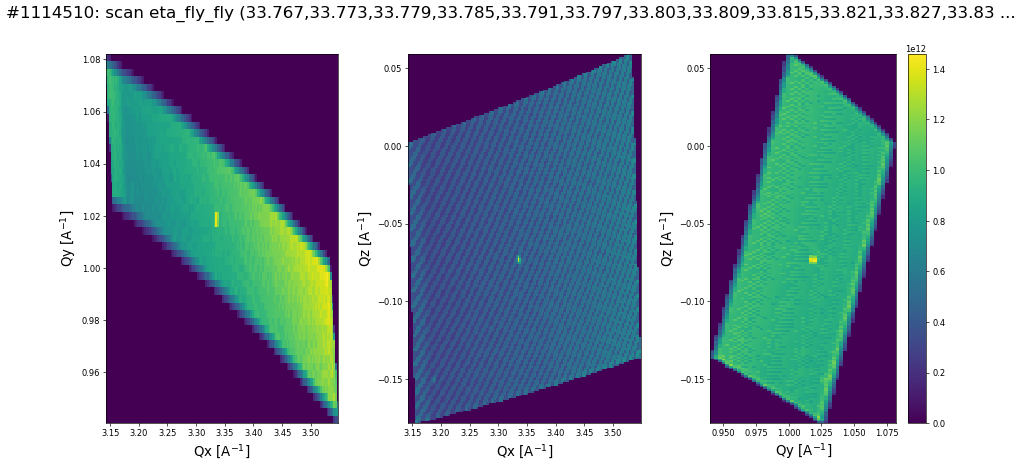

In [14]:
# Plot summed images
plt.figure(figsize=[18, 8], dpi=60)
title = scan.string_format('#{scan_number:.0f}: {scan_command}') 
plt.suptitle(title, fontsize=20)
plt.subplots_adjust(wspace=0.3)


plt.subplot(131)
plt.pcolormesh(qx.mean(axis=2), qy.mean(axis=2), vol.sum(axis=2))
plt.xlabel('Qx [A$^{-1}$]', fontsize=16)
plt.ylabel('Qy [A$^{-1}$]', fontsize=16)
#plt.axis('image')
#plt.colorbar()

plt.subplot(132)
plt.pcolormesh(qx.mean(axis=1), qz.mean(axis=1), vol.sum(axis=1))
plt.xlabel('Qx [A$^{-1}$]', fontsize=16)
plt.ylabel('Qz [A$^{-1}$]', fontsize=16)
#plt.axis('image')
#plt.colorbar()

plt.subplot(133)
L, K = np.meshgrid(l, k)
plt.pcolormesh(qy.mean(axis=0), qz.mean(axis=0), vol.sum(axis=0))
plt.xlabel('Qy [A$^{-1}$]', fontsize=16)
plt.ylabel('Qz [A$^{-1}$]', fontsize=16)
#plt.axis('image')
plt.colorbar()

### |Q| and Two-Theta plots

In [ ]:
qmag = qmag.reshape(-1)
qvol = vol.reshape(-1)
bin_cen = np.arange(qmag.min(), qmag.max(), 0.001)
bin_edge = bin_cen + 0.005
bin_pos = np.digitize(qmag, bin_edge) -1
bin_sum = [np.mean(qvol[bin_pos==n]) for n in range(len(bin_cen))]
tth = cal2theta(bin_cen, energy)

title2 = scan.string_format('#{scan_number:.0f}\n{scan_command}') 

plt.figure(dpi=100)
plt.plot(bin_cen, bin_sum)
plt.title(title2, fontsize=20)
plt.xlabel('|Q| A$^{-1}$', fontsize=20)
plt.ylabel('Intensity', fontsize=20)

plt.figure(dpi=100)
plt.plot(tth, bin_sum)
plt.title(title2, fontsize=20)
plt.xlabel('Two-Theta [Deg]', fontsize=20)
plt.ylabel('Intensity', fontsize=20)